# Movielens Recommendations

Python 2.7

In [168]:
from theano.sandbox import cuda

In [169]:
%matplotlib inline
#import utils; #reload(utils)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers.embeddings import Embedding
from keras.layers import Input, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dense
from keras.layers import merge, add, dot, concatenate
from keras.models import Model, Sequential
from keras import optimizers, regularizers
from keras.optimizers import Adam
from keras.regularizers import l2
#from utils import *
from __future__ import division, print_function
from sklearn.cross_validation import train_test_split
from sklearn import datasets
from keras.optimizers import SGD
#from keras.utils import np_utils
import argparse
import operator # for itemgetter

In [170]:
#path = "data/ml-20m/"
path = "/Users/1355800/Desktop/fast_ai/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=64

## Set up data

We're working with the movielens data, which contains one rating per row, like this:

In [171]:
ratings = pd.read_csv(path+'ratings_100k.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [172]:
len(ratings)

100004

Just for display purposes, let's read in the movie names too.

In [173]:
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

In [174]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [175]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [176]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [177]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [178]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

This is the number of latent factors in each embedding.

In [179]:
n_factors = 50

In [180]:
np.random.seed = 42

Randomly split into training and validation.

In [181]:
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [182]:
g = ratings.groupby("userId")["rating"].count()
topUsers = g.sort_values(ascending=False)[:15]

In [183]:
g = ratings.groupby("movieId")["rating"].count()
topMovies = g.sort_values(ascending=False)[:15]

In [184]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')

In [185]:
top_r = top_r.join(topMovies, rsuffix="_r", how="inner", on="movieId")

In [186]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [187]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [188]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

# number of latent factors in each embedding
n_factors = 50

In [189]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-5)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-5)

/Users/1355800/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(671, 50, embeddings_regularizer=<keras.reg..., input_length=1)`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/1355800/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(9066, 50, embeddings_regularizer=<keras.reg..., input_length=1)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [190]:
x = concatenate([u, m])
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1)(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')
#model.compile(optimizer='Adam', loss='mse')

In [191]:
history = model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=5, 
          validation_data=([val.userId, val.movieId], val.rating), verbose=1)

Train on 80013 samples, validate on 19991 samples
Epoch 1/5
80013/80013 [==============================] - 16s 200us/step - loss: 1.6608 - val_loss: 0.8426
Epoch 2/5
80013/80013 [==============================] - 16s 196us/step - loss: 0.9564 - val_loss: 0.8181
Epoch 3/5
80013/80013 [==============================] - 16s 202us/step - loss: 0.9026 - val_loss: 0.8099
Epoch 4/5
80013/80013 [==============================] - 16s 205us/step - loss: 0.8521 - val_loss: 0.8107
Epoch 5/5
80013/80013 [==============================] - 16s 195us/step - loss: 0.8106 - val_loss: 0.8105


This improves on our already impressive accuracy even further!

In [192]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_in (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
movie_in (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        33550       user_in[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 50)        453300      movie_in[0][0]                   
__________________________________________________________________________________________________
concatenat

In [193]:
# evaluate the model
scores = model.evaluate([trn.userId, trn.movieId], trn.rating)
#print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

80013/80013 [==============================] - 4s 44us/step


## Print Loss

['loss', 'val_loss']


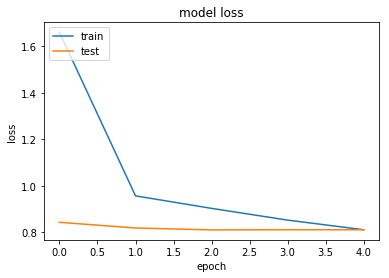

In [194]:
# list all data in history
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Using our model to predict

In [198]:
model.save_weights(model_path+'movielens_recommender_sys.h5')

In [199]:
model.load_weights(model_path+'movielens_recommender_sys.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, the following predicts that user #3 would really enjoy movie #5.

In [200]:
user_id = 31; movie_id = 5
p = model.predict([np.array([user_id]), np.array([movie_id])])
print ('User %d would likely rate movie \'%s\' at %f'%(user_id, movie_names[movies[movie_id]], p))

User 31 would likely rate movie 'Deer Hunter, The (1978)' at 4.397234


## Predict for multiple users

In [202]:
def predict_for_user(user_id, movie_id):
        """
        Predict if a user will like a specific movie.
        Args:
            user_id = The user's user_id.
            movie_id = The movie's movie_id.
        Returns:
            A prediction of how the user would rate the movie.
        """

        prediction = model.predict([np.array([user_id]), np.array([movie_id])])
        prediction = round(prediction, 2)

        # astype(int) converts the numpy float32 value to an integer
        return prediction

In [203]:
def get_movie_name(movie_id):
        """
        Get the name of a movie from it's id.
        Args:
            movie_id = the id for the movie
        
        Returns:
            The movie title for the specified movie_id.
        """
        
        return movie_names[movie_id]

In [224]:
# Predict if user will like a specific movie
users = [1,2,3]
movies = [1,2,41,45]
for user in users:
    for movie in movies:
        movie_name = get_movie_name(movie)
        prediction = predict_for_user(user,movie)
        print('User {}\'s predicted rating for the movie {} is: {}'.format(user, movie_name, prediction))

User 1's predicted rating for the movie Toy Story (1995) is: 3.73
User 1's predicted rating for the movie Jumanji (1995) is: 3.54
User 1's predicted rating for the movie Richard III (1995) is: 2.98
User 1's predicted rating for the movie To Die For (1995) is: 3.42
User 2's predicted rating for the movie Toy Story (1995) is: 3.69
User 2's predicted rating for the movie Jumanji (1995) is: 3.5
User 2's predicted rating for the movie Richard III (1995) is: 2.95
User 2's predicted rating for the movie To Die For (1995) is: 3.38
User 3's predicted rating for the movie Toy Story (1995) is: 4.5
User 3's predicted rating for the movie Jumanji (1995) is: 4.31
User 3's predicted rating for the movie Richard III (1995) is: 3.71
User 3's predicted rating for the movie To Die For (1995) is: 4.18


## Predict for one specific user

In [226]:
users = [3]
movies = [1,2,3,4,5,6,7,8,9,10]
rating_list = []
movie_list = []
for user in users:
    for movie in movies:
        movie_name = get_movie_name(movie)
        user_ratings = predict_for_user(user, movie)
        rating_list.append(user_ratings)
        movie_list.append(movie_name)

In [227]:
user_rating_df = pd.DataFrame({"Movie": movie_list, "Predicted Rating": rating_list}).sort_values(by=['Predicted Rating'], ascending=False)
user_rating_df

,Movie,Predicted Rating
3,Waiting to Exhale (1995),4.94
5,Heat (1995),4.76
6,Sabrina (1995),4.71
4,Father of the Bride Part II (1995),4.62
0,Toy Story (1995),4.50
1,Jumanji (1995),4.31
8,Sudden Death (1995),4.27
2,Grumpier Old Men (1995),4.19
7,Tom and Huck (1995),4.05
9,GoldenEye (1995),3.65


## Predict on all users

In [212]:
# Predictions on all data
pred_array = model.predict(([np.repeat(np.arange(n_users),n_movies),np.tile(np.arange(n_movies),n_users)]))
df_array = np.vstack([np.repeat(np.arange(n_users),n_movies),np.tile(np.arange(n_movies),n_users)]).T

In [213]:
df_pred = pd.DataFrame(pred_array, columns = ['pred'])
df = pd.DataFrame(df_array, columns = ['UserID', 'MovieID'])

In [214]:
df_pred = pd.concat([df, df_pred], axis=1)
df_pred.head()

,UserID,MovieID,pred
0,0,0,2.240251
1,0,1,2.832307
2,0,2,2.642864
3,0,3,2.543159
4,0,4,3.273748
